In [1]:
import numpy as np
from numpy import cos, sin, pi
import matplotlib.pyplot as plt
from scipy.special import jn, eval_chebyt
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

# Question 1

In [2]:
def chebft(a,b,n,func):
    bma = 0.5*(b-a)
    bpa = 0.5*(b+a)
    f = []
    c = []
    for k in range(1,n+1):
        y = cos(pi*(k-0.5)/n)
        f.append(func(y*bma + bpa))
    fac = 2/n
    for j in range(n):
        tot = 0
        for k in range(1,n+1):
            tot += f[k-1]*cos(pi*j*(k-0.5)/n)
        c.append(fac*tot)
    return np.array(c)

def chebeval(x,c,m,a,b):
    val = -0.5*c[0]
    for i in range(m):
        y = -1 + (x-a)*2/(b-a)
        val += eval_chebyt(i,y)*c[i]
    return val

def chder(a,b,c,m):
    cder = [0]*m
    cder[-2] = 2*(m-1)*c[m-1]
    j = m-3
    while j >= 0:
        cder[j] = cder[j+2] + 2*(j+1)*c[j+1]
        j -= 1
    norm_list = [val*2/(b-a) for val in cder]
    return np.array(norm_list)

In [3]:
# only for the range (-1,1)
def fourierfit(func,n):
    c = []
    for i in range(n):
        if i == 0:
            intgnd = lambda x : func(x)/2
        else:
            intgnd = lambda x : func(x)*cos(i*(x+1)*pi/2)
        coeff = quad(intgnd, -1, 1,limit=1000)[0]
        c.append(coeff)
    return c

def fouriereval(x,c,m):
    return np.sum([c[i]*cos(i*(x+1)*pi/2) for i in range(m)])

## Chebyshev Fit for $xJ_1(x)$

In [4]:
# defining the function
def func_1(x):
    return x*jn(1,x)

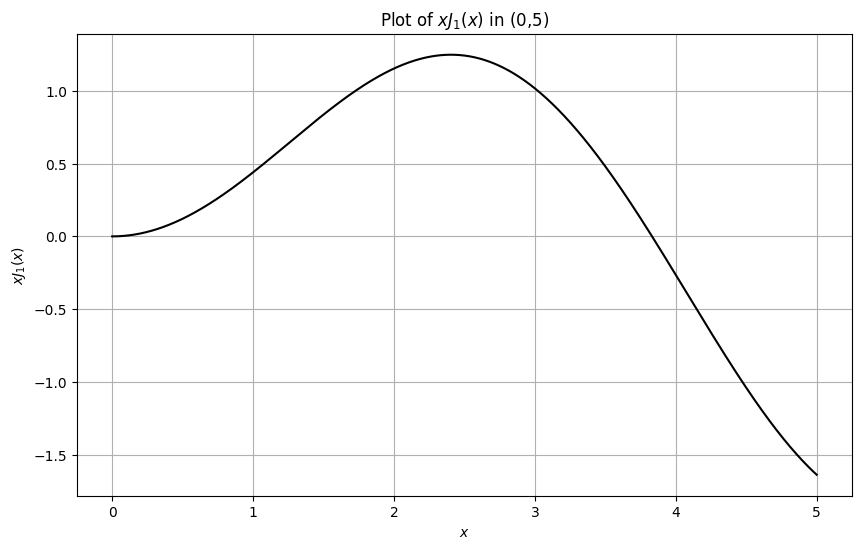

In [5]:
xx = np.linspace(0,5,1000)
yy = func_1(xx)
plt.figure(figsize=(10,6))
plt.plot(xx,yy,'black')
plt.xlabel('$x$')
plt.ylabel('$xJ_1(x)$')
plt.title('Plot of $xJ_1(x)$ in (0,5)')
plt.grid(which='both')
plt.show()

In [6]:
# getting the chebyshev coefficients with N = 50 between (0,5)
c = chebft(0,5,50,func_1)

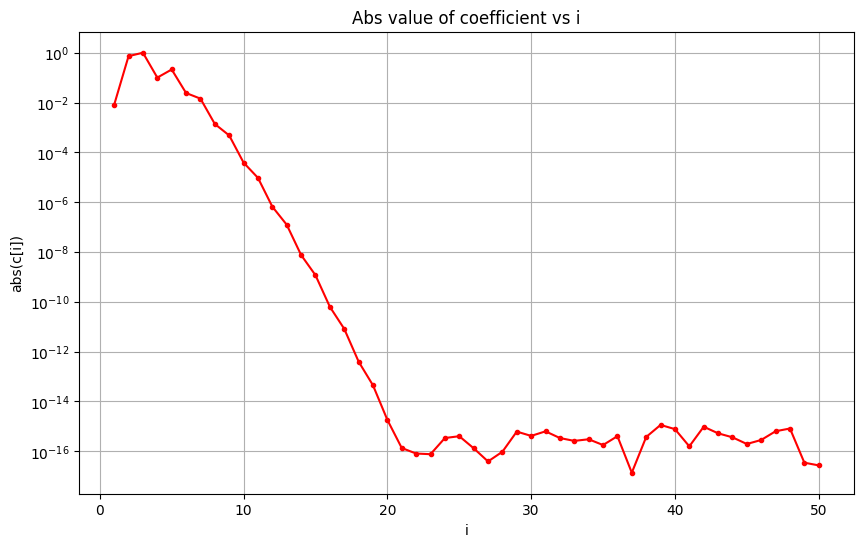

In [7]:
# plotting the coefficients vs 'n'
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i')
plt.grid(which='both')
plt.show()

The abs value of coefficient is close to $1e^{-16}$ around $i=20$, so we choose $m=20$

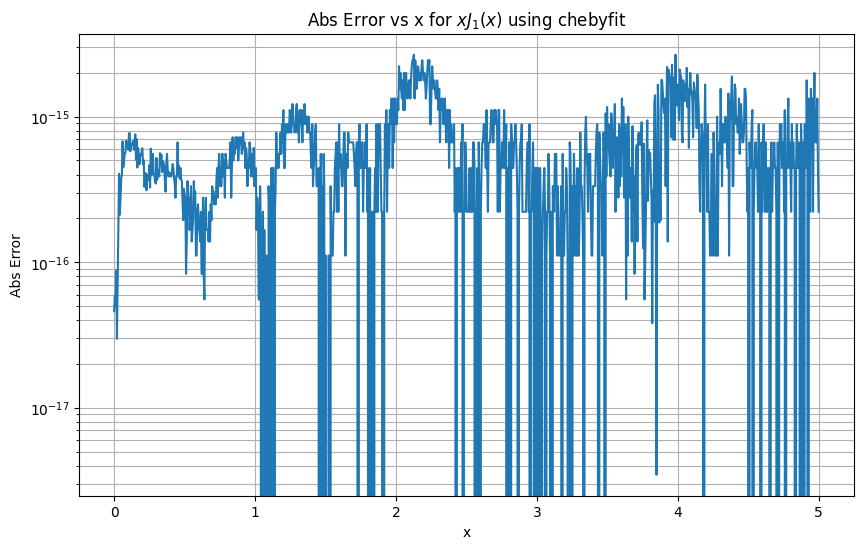

In [8]:
m = 20

yy_cheby = np.array([chebeval(x,c,m,0,5) for x in xx])
err_cheby_1 = np.abs(yy_cheby - yy)
plt.figure(figsize=(10,6))
plt.semilogy(xx,err_cheby_1)
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for $xJ_1(x)$ using chebyfit')
plt.show()

## Chebyshev fit for $\dfrac{d(xJ_1(x))}{dx}$

In [9]:
# defining the exact derivative of func_1
def func_1_der(x):
    return x*jn(0,x)

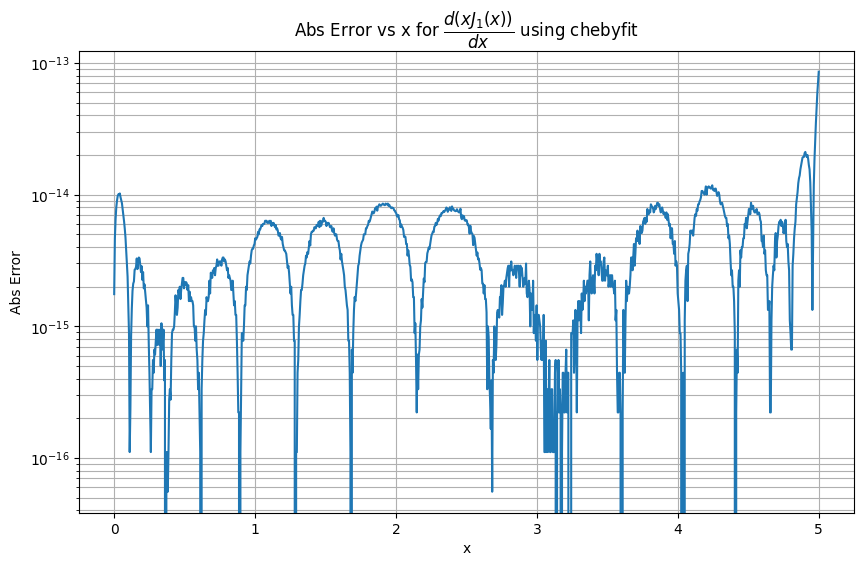

In [10]:
# Error plot for cheby_derivative
cder = chder(0,5,c,m)

yy_der = func_1_der(xx)
yy_der_cheby = np.array([chebeval(x,cder,m,0,5) for x in xx])
err_cheby_der = np.abs(yy_der_cheby - yy_der)
plt.figure(figsize=(10,6))
plt.semilogy(xx,err_cheby_der)
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for $\dfrac{d(xJ_1(x))}{dx}$ using chebyfit')
plt.show()

## Using difference of samples

In [11]:
def func_1_der_cen(x, delta):
    return (func_1(x + delta/2) - func_1(x - delta/2))/delta

def func_1_der_noncen(x, delta):
    return (func_1(x + delta) - func_1(x))/delta

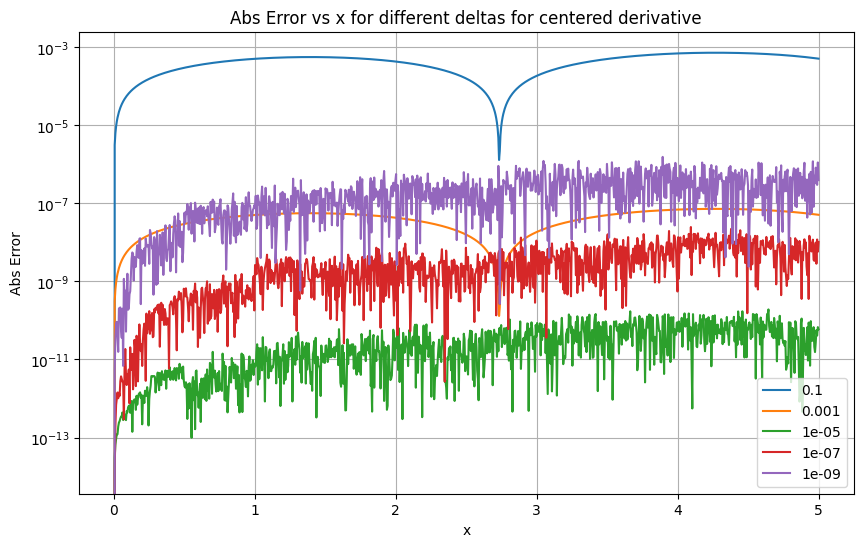

In [12]:
deltas = [1e-1,1e-3, 1e-5, 1e-7,1e-9]
err_cen = []
xx = np.linspace(0,5,1000)
yy = np.array(func_1_der(xx))
for delta in deltas:
    yy_der_cen = np.array([func_1_der_cen(x,delta) for x in xx])
    err_cen.append(np.abs(yy_der_cen - yy))
plt.figure(figsize=(10,6))
plt.semilogy(xx,np.transpose(np.array(err_cen)))
plt.legend(deltas)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different deltas for centered derivative')
plt.show()

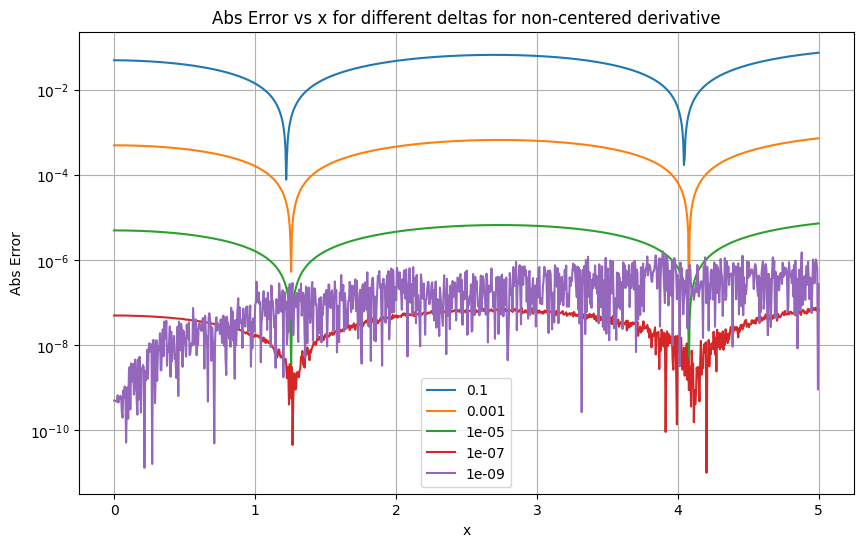

In [13]:
err_noncen = []
xx = np.linspace(0,5,1000)
yy = np.array(func_1_der(xx))
for delta in deltas:
    yy_der_noncen = np.array([func_1_der_noncen(x,delta) for x in xx])
    err_noncen.append(np.abs(yy_der_noncen - yy))
plt.figure(figsize=(10,6))
plt.semilogy(xx,np.transpose(np.array(err_noncen)))
plt.legend(deltas)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different deltas for non-centered derivative')
plt.show()

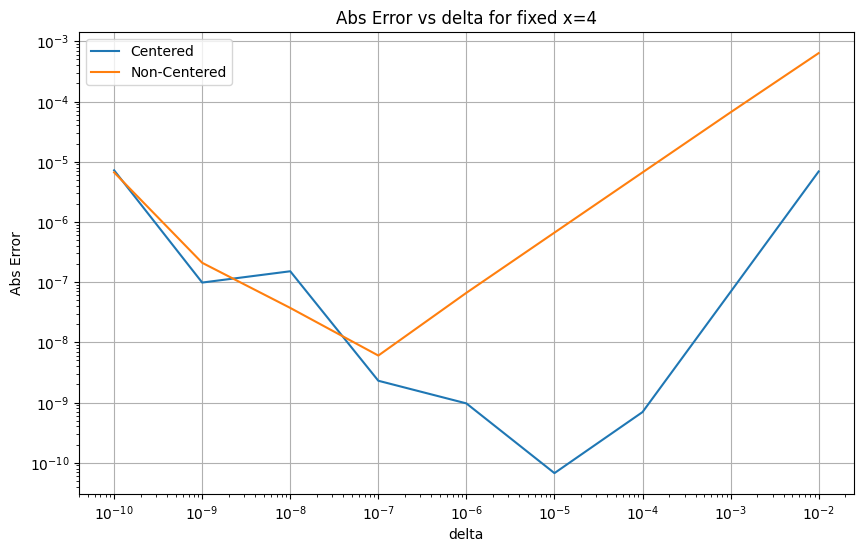

In [14]:
# fixing x = 4 varying delta finding the error
# for centered
x = 4
exact = func_1_der(x)
deltas = np.array([10**i for i in range(-10,-1,1)])
cen_err = np.array([np.abs(func_1_der_cen(x,delta)-exact) for delta in deltas])
noncen_err = np.array([np.abs(func_1_der_noncen(x,delta)-exact) for delta in deltas])
plt.figure(figsize=(10,6))
plt.loglog(deltas,cen_err)
plt.loglog(deltas,noncen_err)
plt.legend(['Centered','Non-Centered'])
plt.grid('both')
plt.xlabel('delta')
plt.ylabel('Abs Error')
plt.title(f'Abs Error vs delta for fixed x={x}')
plt.show()

# Question 2

## Chebyshev fit for $sin(\pi x)$

In [51]:
def func(x):
    return sin(pi*x)

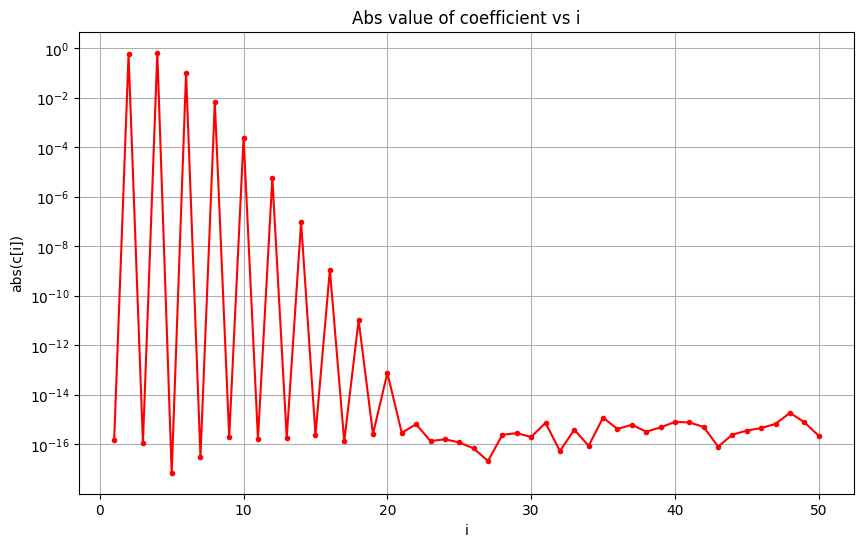

In [52]:
# getting the chebyshev coefficients with N=50
c = chebft(-1,1,50,func)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i')
plt.grid(which='both')
plt.show()

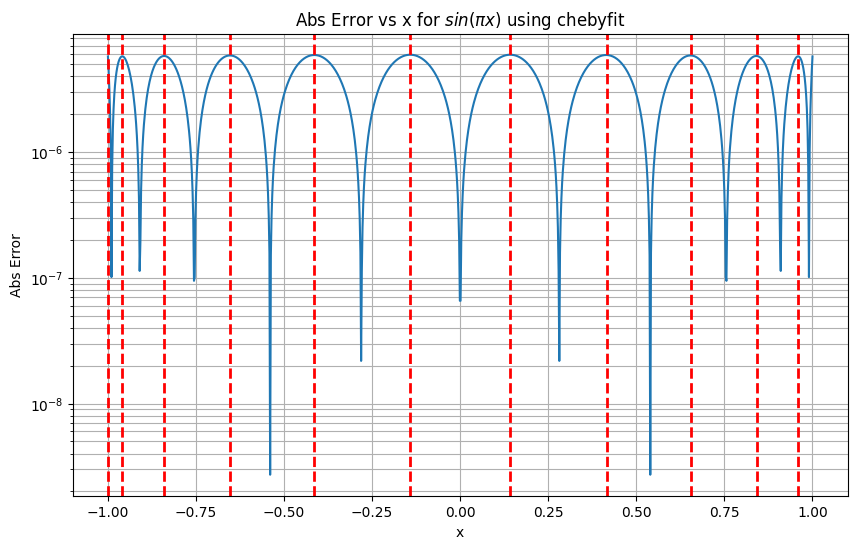

In [54]:
xx = np.linspace(-1,1,1000)
yy = func(xx)
yy_cheby = np.array([chebeval(x,c,10,-1,1) for x in xx])
err_cheby = np.abs(yy_cheby - yy)
plt.figure(figsize=(10,6))
plt.semilogy(xx,err_cheby)
for i in np.array([cos(pi*(k)/11) for k in range(1,12)]):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=2)
plt.grid(which='both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for $sin( \pi x)$ using chebyfit')
plt.show()

# Question 3

## Chebyshev Fitting

### $f(x) = e^x$

In [18]:
def f(x):
    return np.exp(x)

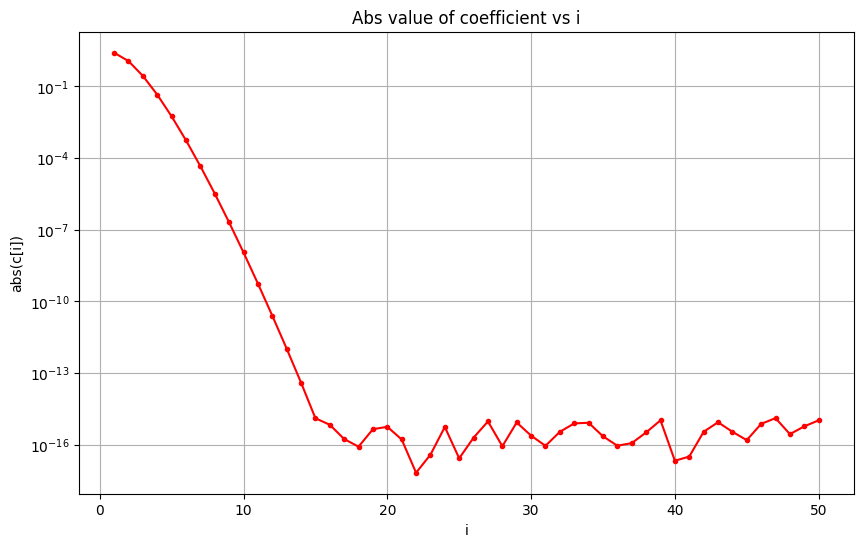

In [19]:
c = chebft(-1,1,50,f)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i')
plt.grid(which='both')
plt.show()

In [20]:
xx = np.linspace(-1,1,1000)
yy = f(xx)
err_f = []
for m in range(10,17):
    yy_cheb_f = np.array([chebeval(x,c,m,-1,1) for x in xx])
    err_cheb_f = np.abs(yy_cheb_f - yy)
    err_f.append(err_cheb_f)
err_f = np.array(err_f)

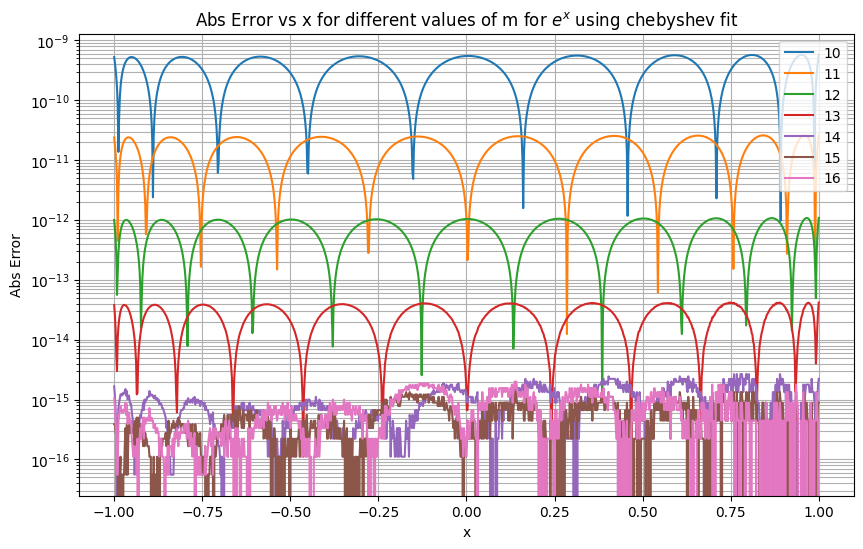

In [21]:
plt.figure(figsize=(10,6))
plt.semilogy(xx,np.transpose(err_f))
plt.legend(list(range(10,17)))
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of m for $e^x$ using chebyshev fit')
plt.grid(which='both')
plt.show()

### $g(x) = \dfrac{1}{x^2 + \delta^2}$

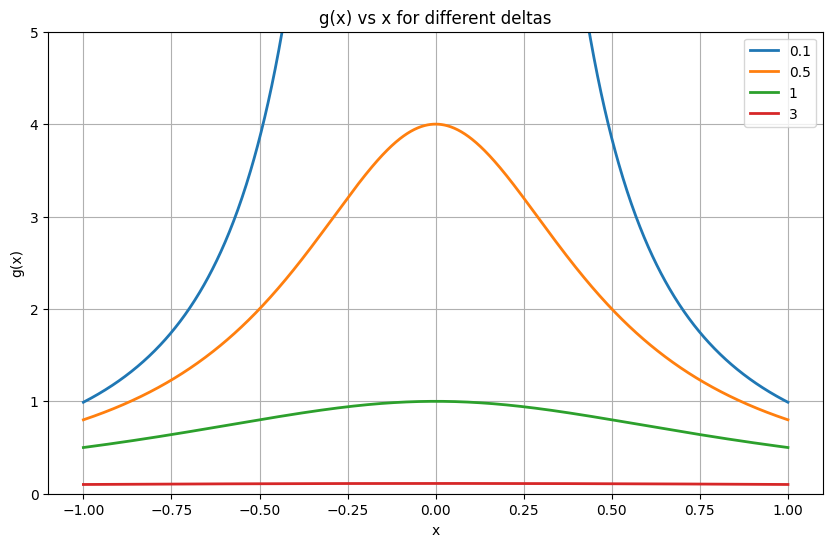

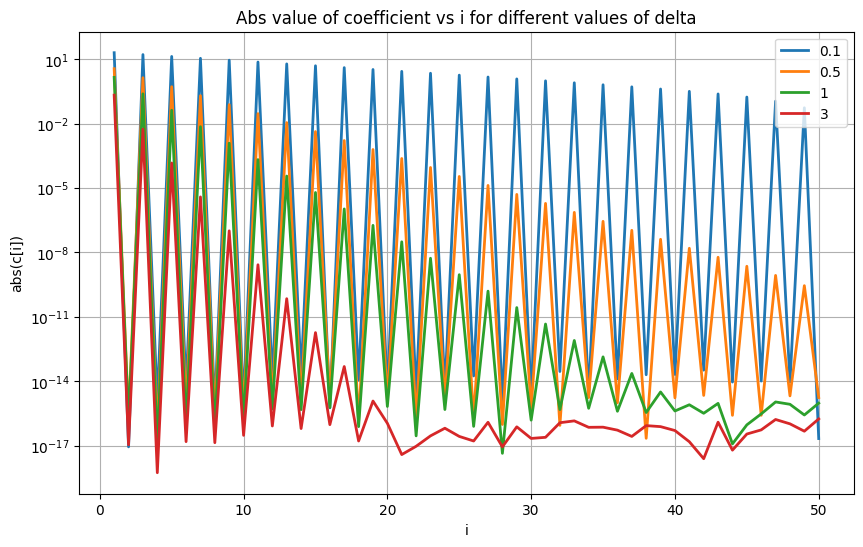

In [22]:
deltas = [0.1,0.5,1,3]

# plotting the functions 
xx = np.linspace(-1,1,1000)
yy = []
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    yy.append(np.array([g(x) for x in xx]))
yy = np.array(yy)
plt.figure(figsize=(10,6))
plt.plot(xx,np.transpose(yy),linewidth=2)
plt.ylim([0,5])
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('g(x) vs x for different deltas')
plt.legend(deltas)
plt.grid('both')
plt.show()

# coefficients vs delta
c_vals = []
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    c = chebft(-1,1,50,g)
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

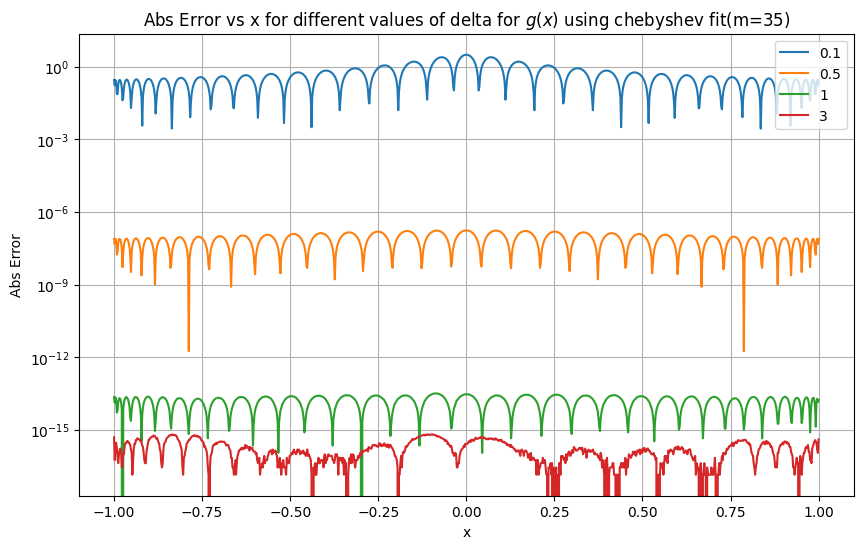

In [23]:
err_g = []
xx = np.linspace(-1,1,1000)
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    c = chebft(-1,1,50,g)
    yy_true = g(xx)
    yy_cheb_g = np.array([chebeval(x,c,35,-1,1) for x in xx])
    err_g.append(np.abs(yy_cheb_g - yy_true))
plt.figure(figsize=(10,6))
plt.semilogy(xx, np.transpose(err_g))
plt.legend(deltas)
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of delta for $g(x)$ using chebyshev fit(m=35)')
plt.grid(which='both')
plt.show()

### $h(x) = \dfrac{1}{sin^2(\pi x/2) + \delta^2}$

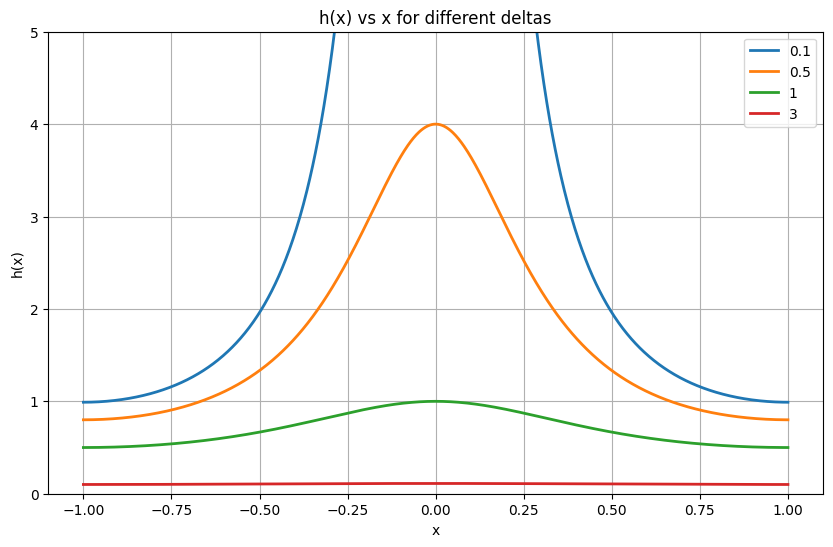

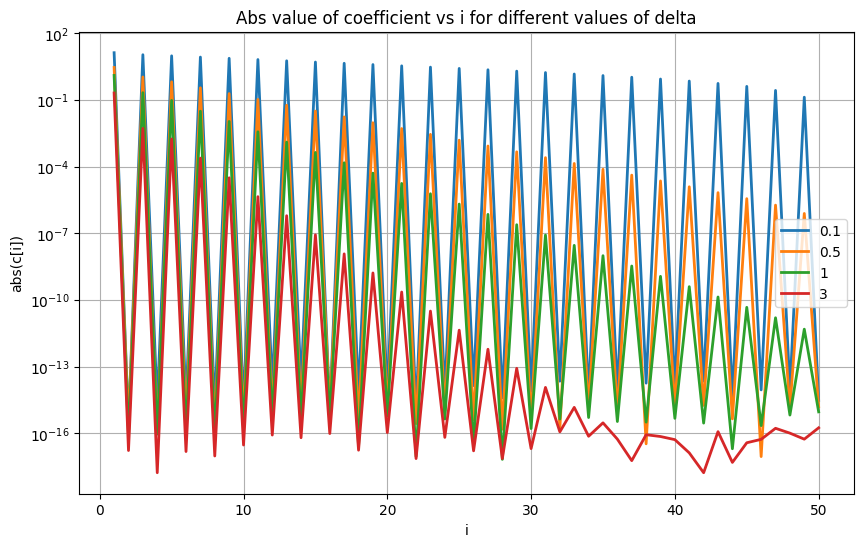

In [24]:
deltas = [0.1,0.5,1,3]

def h_og(x,delta):
    dem = sin(pi*x/2)**2 + delta**2
    return 1/dem

# plotting the functions 
xx = np.linspace(-1,1,1000)
yy = []
for delta in deltas:
    h = lambda x : h_og(x,delta)
    yy.append(np.array([h(x) for x in xx]))
yy = np.array(yy)
plt.figure(figsize=(10,6))
plt.plot(xx,np.transpose(yy),linewidth=2)
plt.ylim([0,5])
plt.xlabel('x')
plt.ylabel('h(x)')
plt.title('h(x) vs x for different deltas')
plt.legend(deltas)
plt.grid('both')
plt.show()

# coefficients vs delta
c_vals = []
for delta in deltas:
    h = lambda x : h_og(x,delta)
    c = chebft(-1,1,50,h)
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

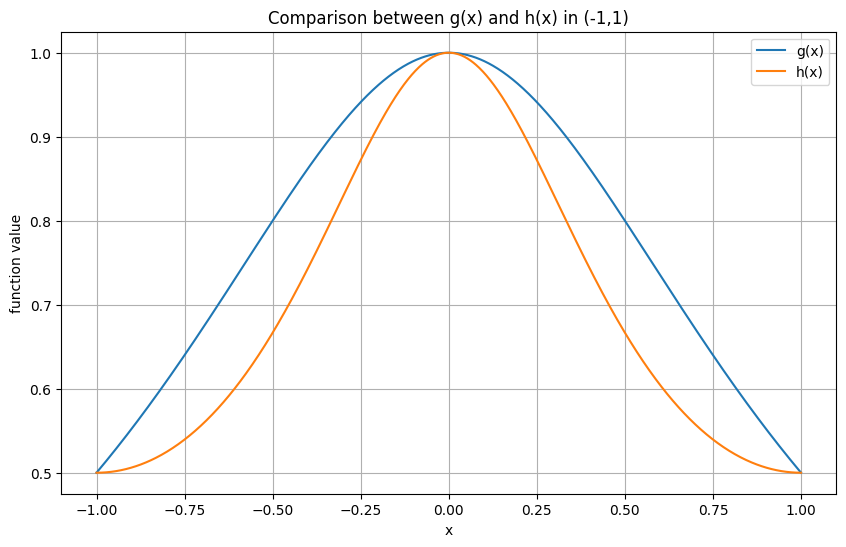

In [25]:
# comparing g(x) and h(x) for delta = 1
xx = np.linspace(-1,1,1000)
y = []
g = lambda x : 1/(x**2 + 1)
h = lambda x : h_og(x,1)
y.append(g(xx))
y.append(h(xx))
y = np.array(y)
plt.figure(figsize=(10,6))
plt.plot(xx,np.transpose(y))
plt.legend(['g(x)','h(x)'])
plt.xlabel('x')
plt.ylabel('function value')
plt.title('Comparison between g(x) and h(x) in (-1,1)')
plt.grid('both')
plt.show()

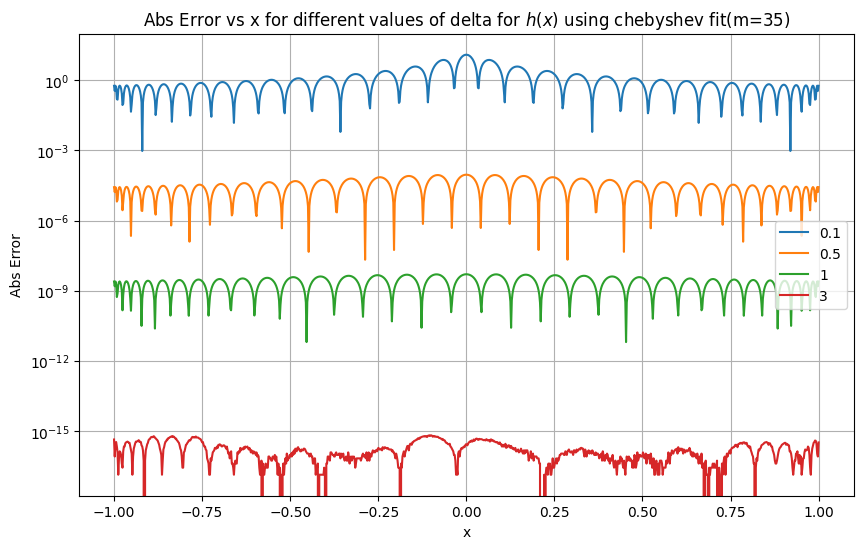

In [26]:
err_h = []
xx = np.linspace(-1,1,1000)
for delta in deltas:
    h = lambda x : h_og(x,delta)
    c = chebft(-1,1,50,h)
    yy_true = h(xx)
    yy_cheb_h = np.array([chebeval(x,c,35,-1,1) for x in xx])
    err_h.append(np.abs(yy_cheb_h - yy_true))
plt.figure(figsize=(10,6))
plt.semilogy(xx, np.transpose(err_h))
plt.legend(deltas)
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of delta for $h(x)$ using chebyshev fit(m=35)')
plt.grid(which='both')
plt.show()

### $u(x) = e^{-|x|}$

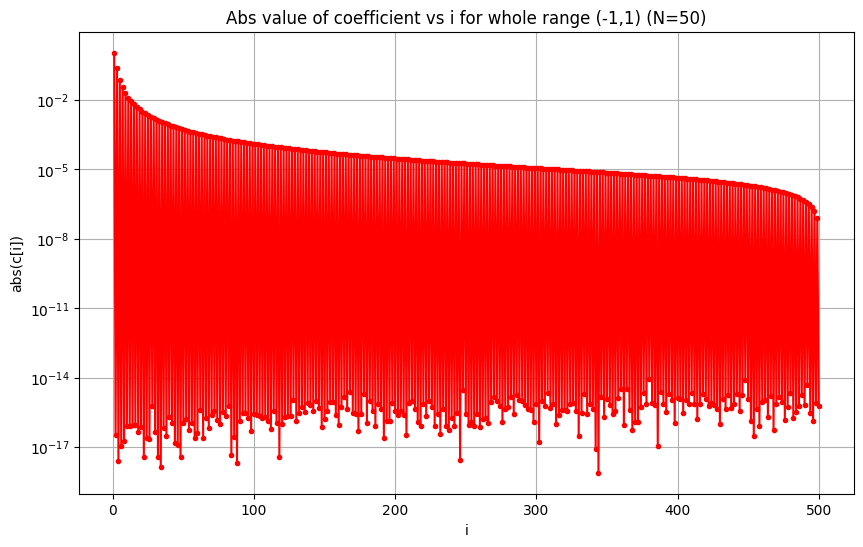

In [58]:
# taking the whole range
def u(x):
    return np.exp(-np.abs(x))

c = chebft(-1,1,500,u)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,501),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for whole range (-1,1) (N=50)')
plt.grid(which='both')
plt.show()

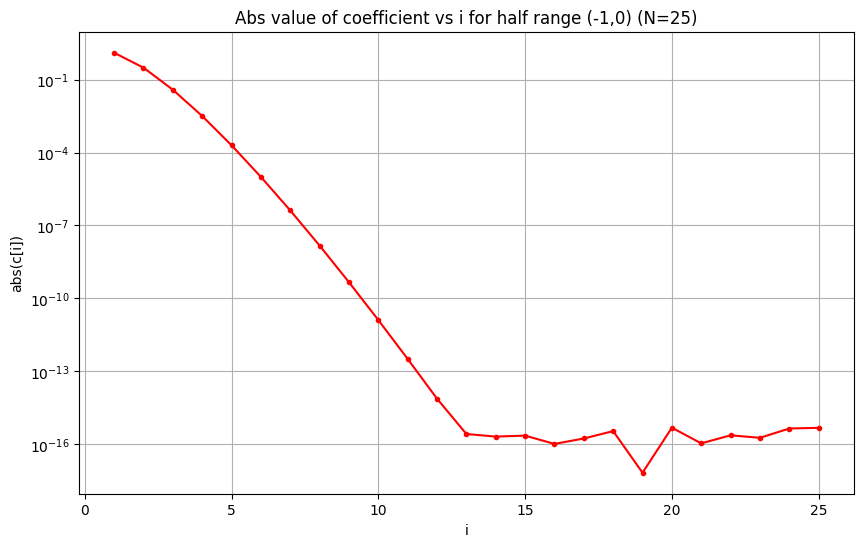

In [28]:
c_half = chebft(-1,0,25,u)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,26),np.abs(c_half),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for half range (-1,0) (N=25)')
plt.grid(which='both')
plt.show()

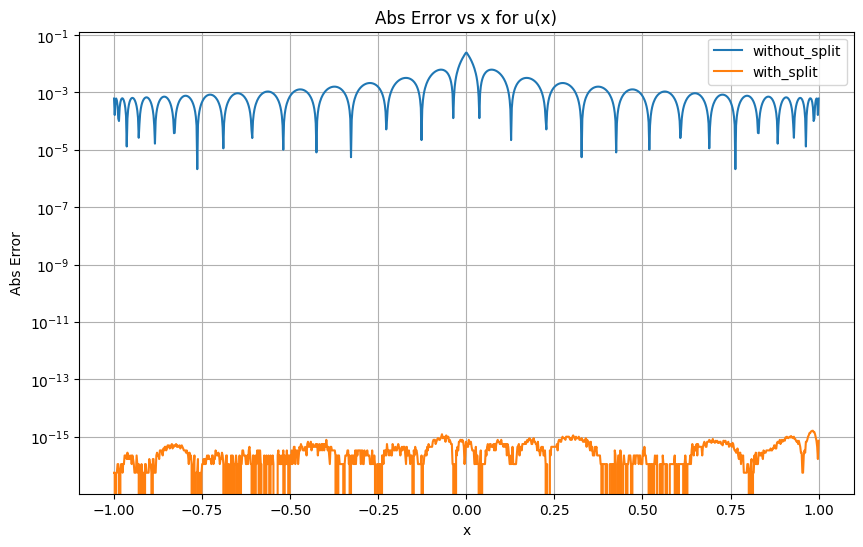

In [29]:
xx = np.linspace(-1,1,1000)
yy = u(xx)

# taking the whole range
yy_cheb_u_whole = np.array([chebeval(x,c,30,-1,1) for x in xx])
err_u_whole = np.abs(yy_cheb_u_whole - yy)

# splitting the range
xx_half1 = np.linspace(-1,0,500)
xx_half2 = np.linspace(0,1,500)
yy_true = np.array([u(x) for x in xx_half1] + [u(x) for x in xx_half2])
c_half1 = chebft(-1,0,25,u)
c_half2 = chebft(0,1,25,u)
yy_cheb_u_split = np.array([chebeval(x,c_half1,15,-1,0) for x in xx_half1] + 
                           [chebeval(x,c_half2,15,0,1) for x in xx_half2])
err_u_split = np.abs(yy_cheb_u_split - yy_true)

plt.figure(figsize=(10,6))
plt.semilogy(xx,err_u_whole)
plt.semilogy(xx,err_u_split)
plt.legend(['without_split','with_split'])
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for u(x)')
plt.show()

### $v(x) = \sqrt{x + 1.1}$

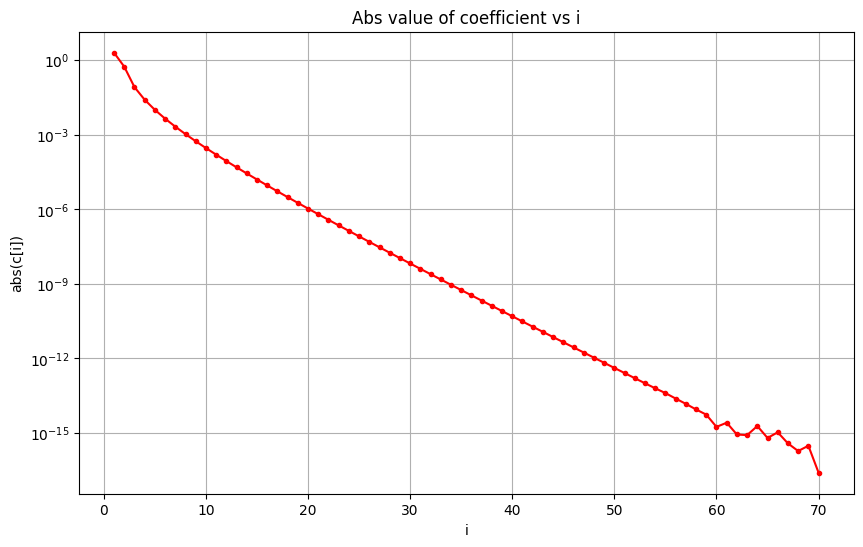

In [30]:
def v(x):
    return np.sqrt(x + 1.1)

c = chebft(-1,1,70,v)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,71),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i')
plt.grid(which='both')
plt.show()

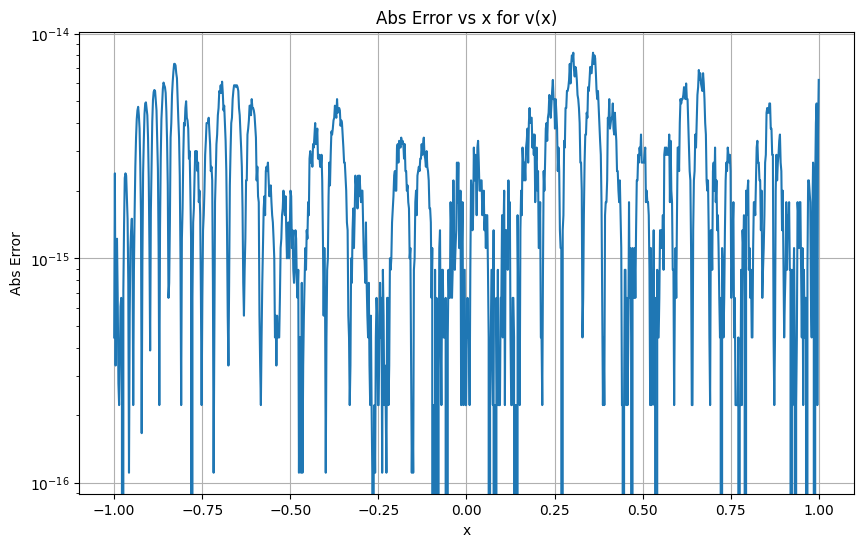

In [31]:
xx = np.linspace(-1,1,1000)
yy = v(xx)
yy_cheb_v = np.array([chebeval(x,c,65,-1,1) for x in xx])
err_cheb_v = np.abs(yy_cheb_v - yy)
plt.figure(figsize=(10,6))
plt.semilogy(xx,err_cheb_v)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for v(x)')
plt.show()

## Fourier fitting

### $f(x) = e^x$

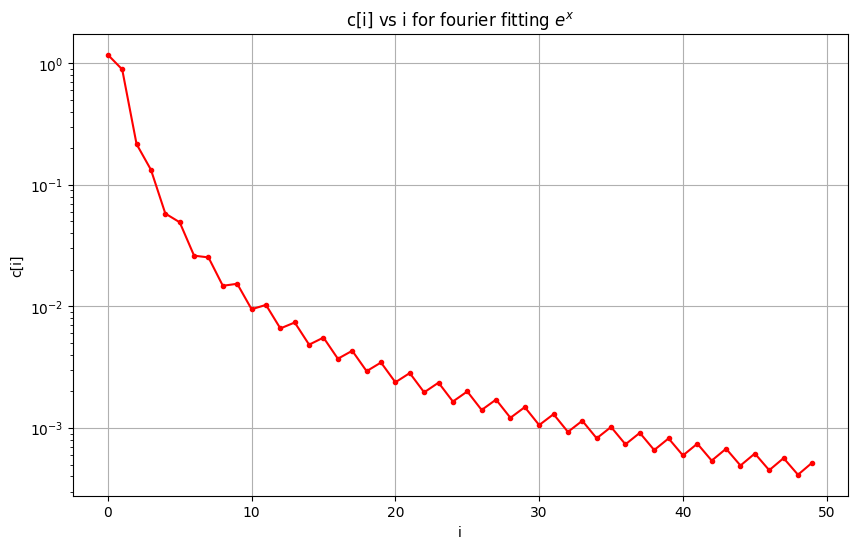

In [32]:
f = lambda x : np.exp(x)
c = fourierfit(f,50)
plt.figure(figsize=(10,6))
plt.semilogy(range(50),np.abs(c),'ro-',markersize=3)
plt.grid('both')
plt.xlabel('i')
plt.ylabel('c[i]')
plt.title('c[i] vs i for fourier fitting $e^x$')
plt.show()

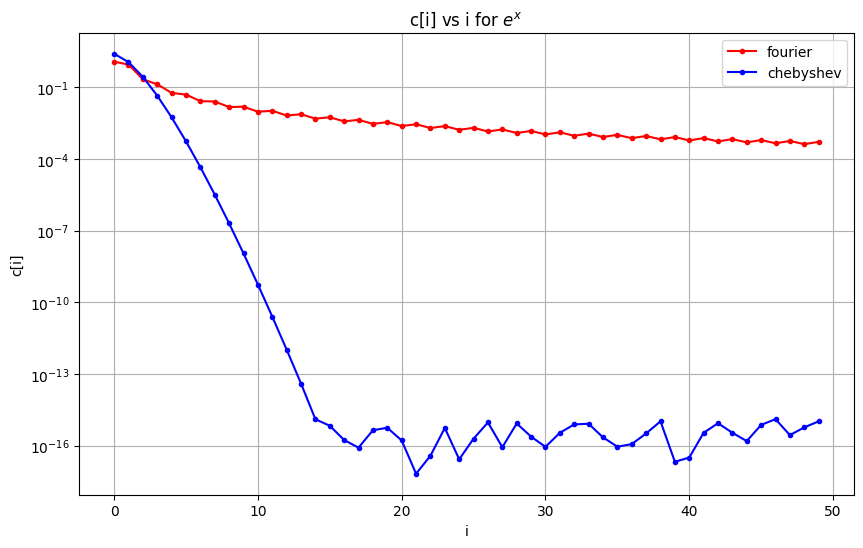

In [33]:
# comparing fourier fit with chebyshev fit
c_cheb_ex = chebft(-1,1,50,f)
plt.figure(figsize=(10,6))
plt.semilogy(range(50),np.abs(c),'ro-',range(50),np.abs(c_cheb_ex),'bo-',markersize=3)
plt.grid('both')
plt.legend(['fourier','chebyshev'])
plt.xlabel('i')
plt.ylabel('c[i]')
plt.title('c[i] vs i for $e^x$')
plt.show()

In [34]:
# error plot for fourier
xx = np.linspace(-1,1,1000)
yy = f(xx)
err_f = []
for m in range(5,30,5):
    yy_four_f = np.array([fouriereval(x,c,m) for x in xx])
    err_four_f = np.abs(yy_four_f - yy)
    err_f.append(err_four_f)
err_f = np.array(err_f)

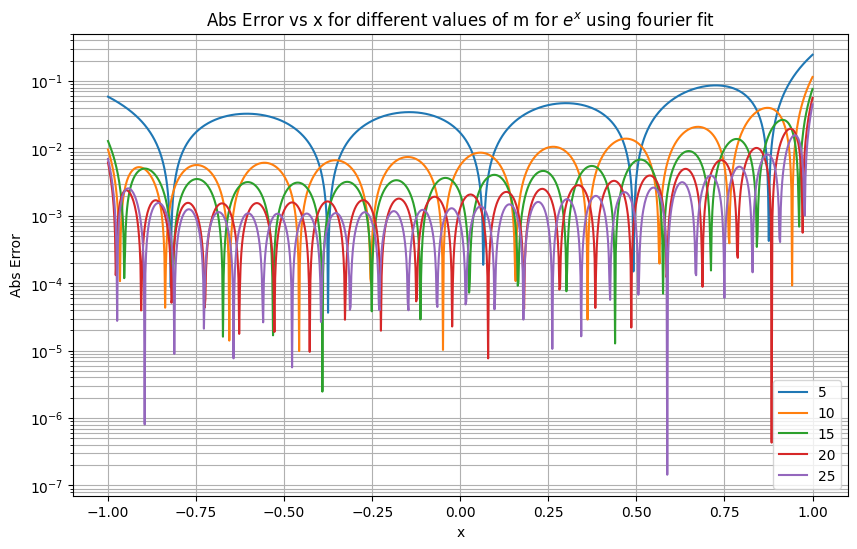

In [35]:
plt.figure(figsize=(10,6))
plt.semilogy(xx,np.transpose(err_f))
plt.legend(list(range(5,30,5)))
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of m for $e^x$ using fourier fit')
plt.grid(which='both')
plt.show()

### $g(x) = \dfrac{1}{x^2 + \delta^2}$

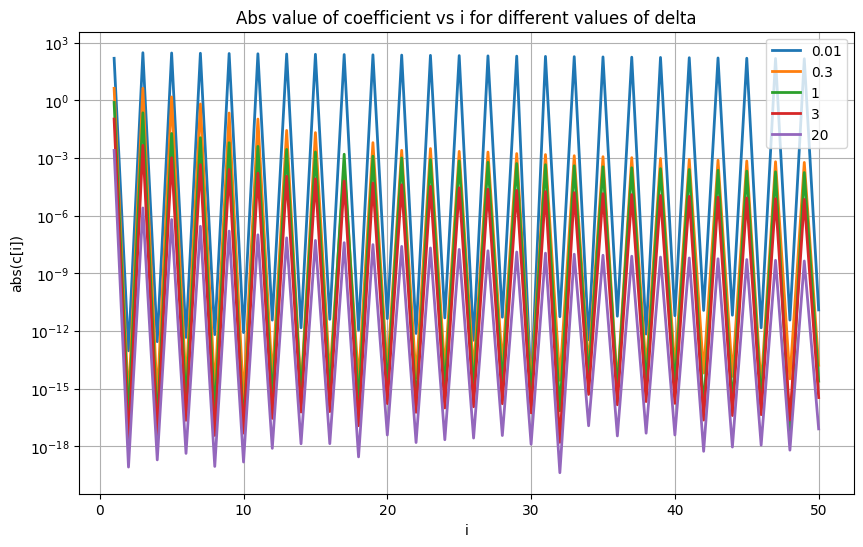

In [36]:
deltas = [0.01,0.3,1,3,20]

# coefficients vs delta
c_vals = []
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    c = fourierfit(g,50)
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

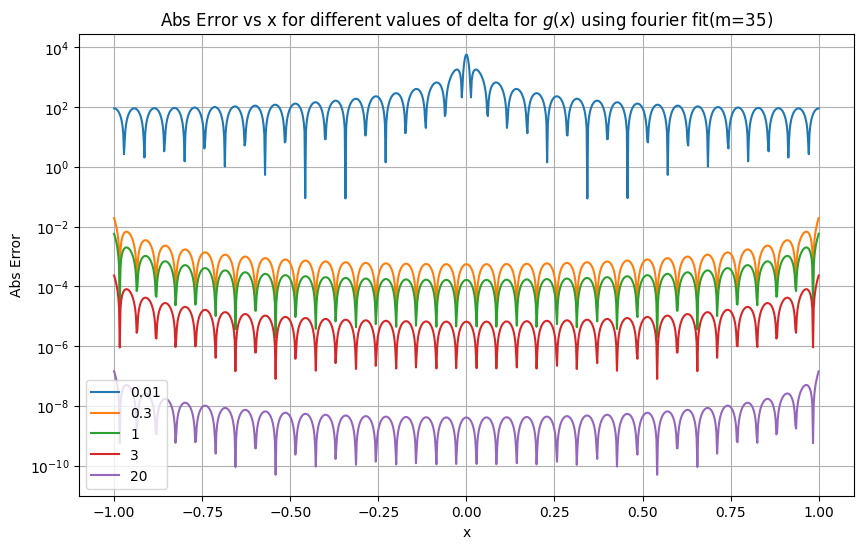

In [37]:
err_g = []
xx = np.linspace(-1,1,1000)
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    c = fourierfit(g,50)
    yy_true = g(xx)
    yy_four_g = np.array([fouriereval(x,c,35) for x in xx])
    err_g.append(np.abs(yy_four_g - yy_true))
plt.figure(figsize=(10,6))
plt.semilogy(xx, np.transpose(err_g))
plt.legend(deltas)
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of delta for $g(x)$ using fourier fit(m=35)')
plt.grid(which='both')
plt.show()

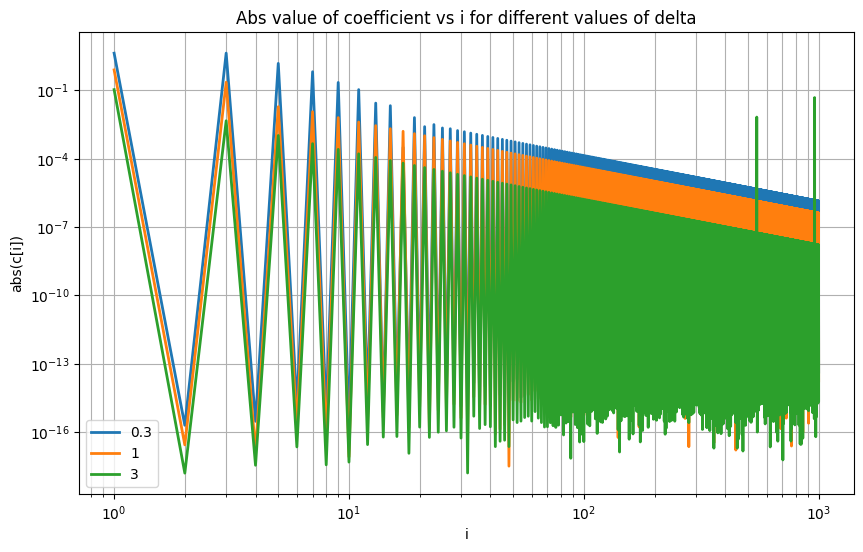

In [38]:
# comparison between delta=0.3 and 1, 3
deltas = [0.3,1,3]
# coefficients vs delta
c_vals = []
for delta in deltas:
    g = lambda x : 1/(x**2 + delta**2)
    c = fourierfit(g,int(1e3))
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.loglog(range(1,int(1e3)+1),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

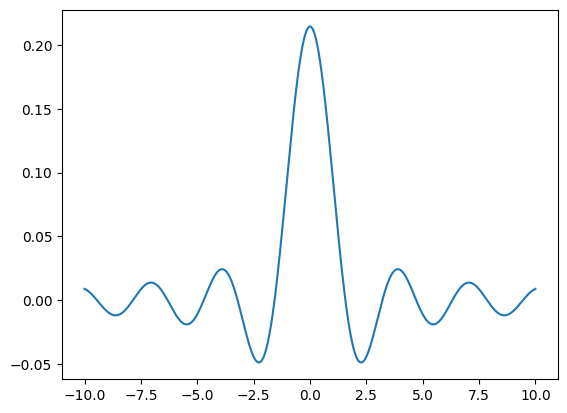

In [39]:
ws = np.linspace(-10,10,1000)
c = []
for w in ws:
    f = lambda x : (1/(x**2 + 9))*cos(w*(x+1))
    c.append(quad(f,-1,1)[0])
plt.plot(ws,c)
plt.show()

### $h(x) = \dfrac{1}{\sin^2(\pi x/2) + \delta^2}$

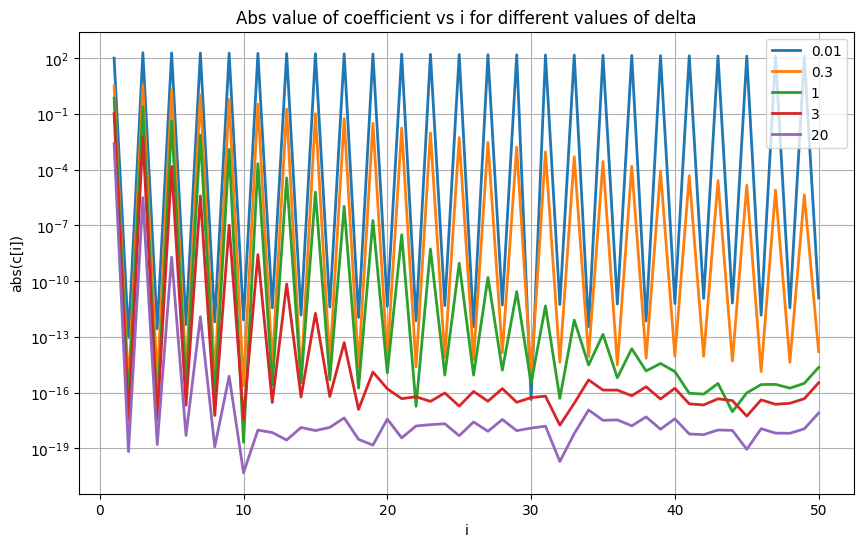

In [55]:
deltas = [0.01,0.3,1,3,20]

# coefficients vs delta
c_vals = []
for delta in deltas:
    h = lambda x : 1/(sin(pi*x/2)**2 + delta**2)
    c = fourierfit(h,50)
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

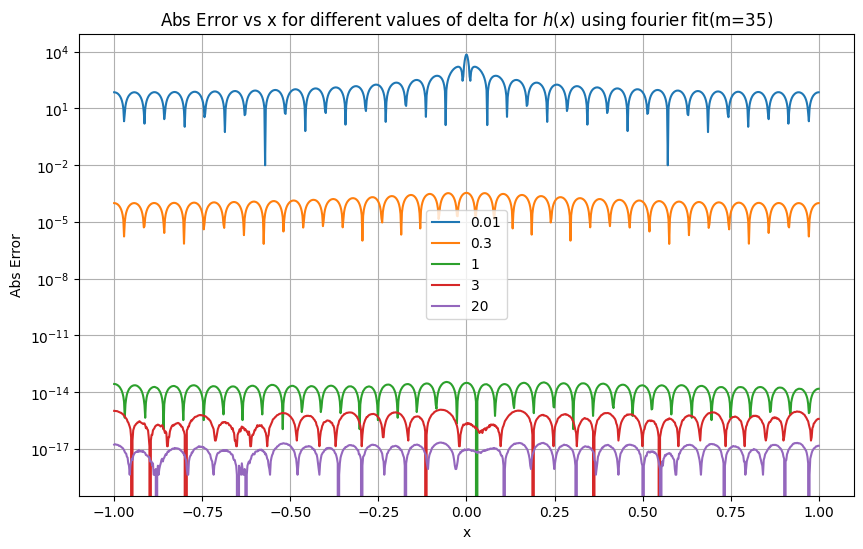

In [56]:
err_h = []
xx = np.linspace(-1,1,1000)
for delta in deltas:
    h = lambda x : 1/(sin(pi*x/2)**2 + delta**2)
    c = fourierfit(h,50)
    yy_true = h(xx)
    yy_four_h = np.array([fouriereval(x,c,35) for x in xx])
    err_h.append(np.abs(yy_four_h - yy_true))
plt.figure(figsize=(10,6))
plt.semilogy(xx, np.transpose(err_h))
plt.legend(deltas)
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for different values of delta for $h(x)$ using fourier fit(m=35)')
plt.grid(which='both')
plt.show()

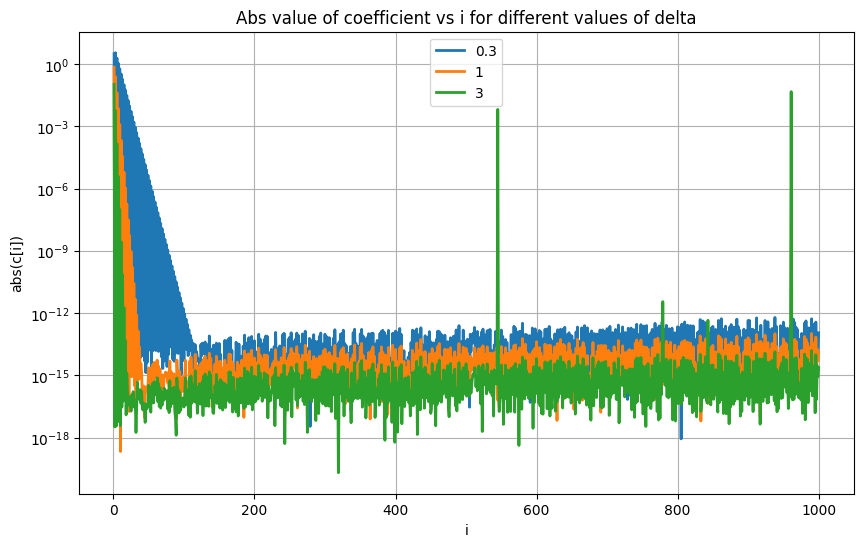

In [57]:
# comparison between delta=0.3 and 1, 3
deltas = [0.3,1,3]
# coefficients vs delta
c_vals = []
for delta in deltas:
    h = lambda x : 1/(sin(pi*x/2)**2 + delta**2)
    c = fourierfit(h,int(1e3))
    c_vals.append(c)
c_vals = np.array(c_vals)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,int(1e3)+1),np.transpose(np.abs(c_vals)),linewidth=2)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i for different values of delta')
plt.legend(deltas)
plt.grid(which='both')
plt.show()

### $u(x) = e^{-|x|}$

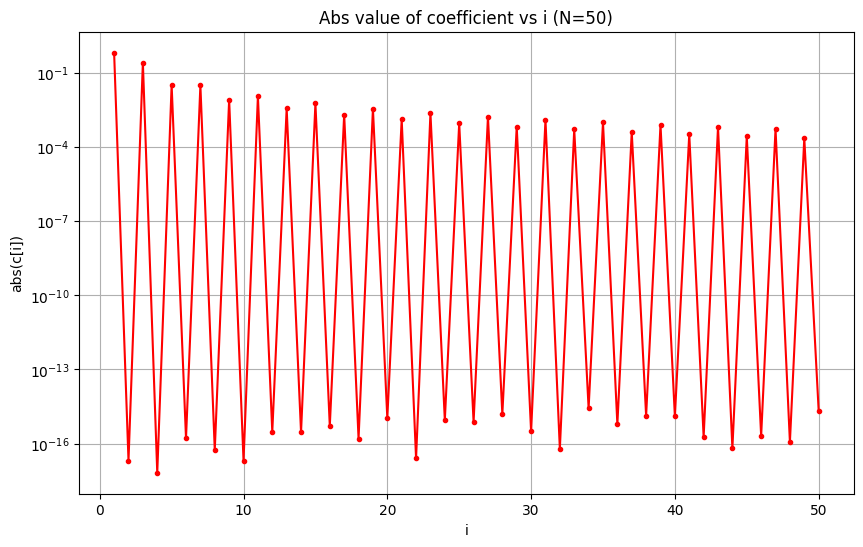

In [43]:
def u(x):
    return np.exp(-np.abs(x))

c = fourierfit(u,50)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,51),np.abs(c),'ro-',markersize=3)
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i (N=50)')
plt.grid(which='both')
plt.show()

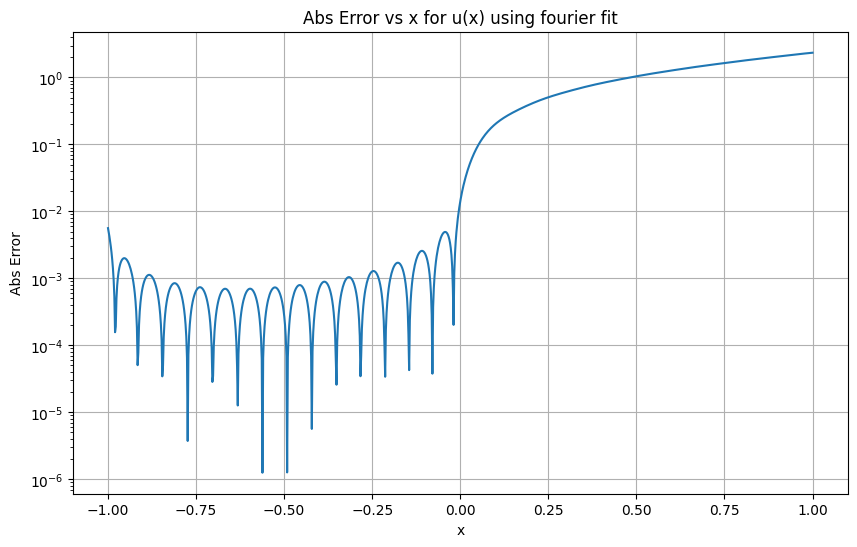

In [44]:
# taking the whole range
yy_four_u_whole = np.array([fouriereval(x,c,30) for x in xx])
err_u_whole = np.abs(yy_four_u_whole - yy)

plt.figure(figsize=(10,6))
plt.semilogy(xx,err_u_whole)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for u(x) using fourier fit')
plt.show()

### $v(x) = \sqrt{x + 1.1} $

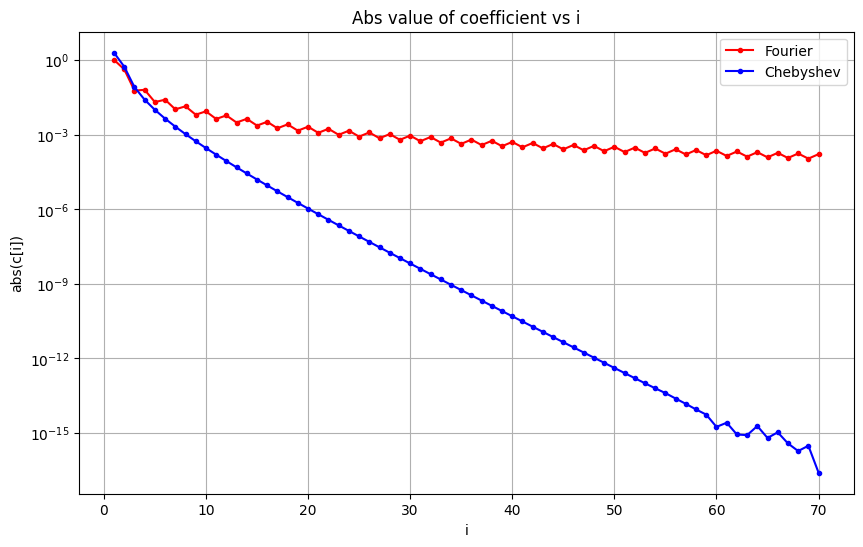

In [45]:
def v(x):
    return np.sqrt(x + 1.1)

c_cheb = chebft(-1,1,70,v)
c = fourierfit(v,70)
plt.figure(figsize=(10,6))
plt.semilogy(range(1,71),np.abs(c),'ro-',markersize=3)
plt.semilogy(range(1,71),np.abs(c_cheb),'bo-',markersize=3)
plt.legend(['Fourier','Chebyshev'])
plt.xlabel('i')
plt.ylabel('abs(c[i])')
plt.title('Abs value of coefficient vs i')
plt.grid(which='both')
plt.show()

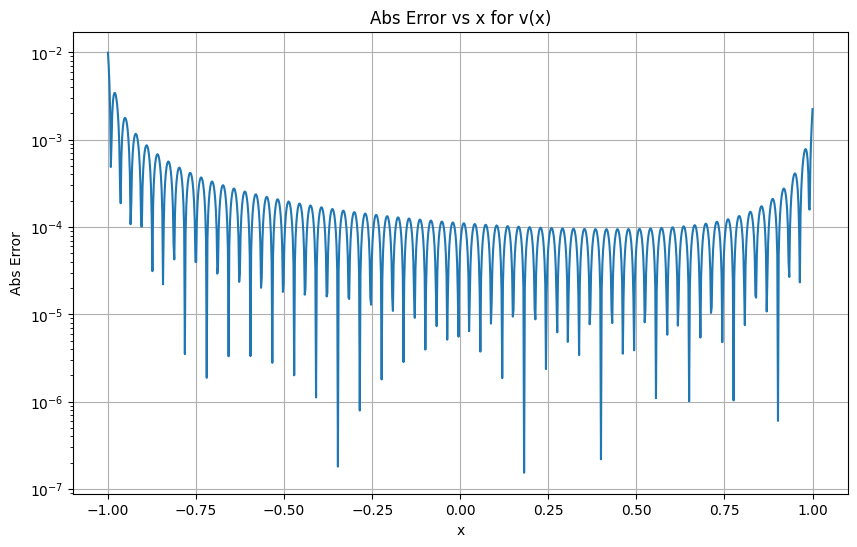

In [46]:
xx = np.linspace(-1,1,1000)
yy = v(xx)
yy_four_v = np.array([fouriereval(x,c,65) for x in xx])
err_four_v = np.abs(yy_four_v - yy)
plt.figure(figsize=(10,6))
plt.semilogy(xx,err_four_v)
plt.grid('both')
plt.xlabel('x')
plt.ylabel('Abs Error')
plt.title('Abs Error vs x for v(x)')
plt.show()

## Fast Fourier Transform

In [47]:
def f(x):
    return np.exp(x)

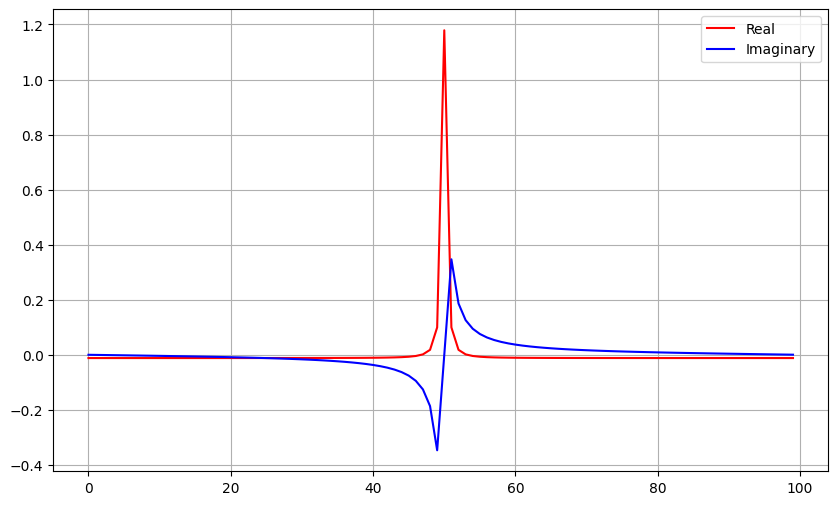

In [48]:
N = 100
x = np.linspace(-1,1,N)
y = np.array([f(i) for i in x])
fft_coeff = np.fft.fft(y)/N
fft_shifted_coeff = np.fft.fftshift(fft_coeff)
plt.figure(figsize=(10,6))
plt.plot(fft_shifted_coeff.real,'r',fft_shifted_coeff.imag,'b')
plt.legend(['Real','Imaginary'])
plt.grid('both')
plt.show()

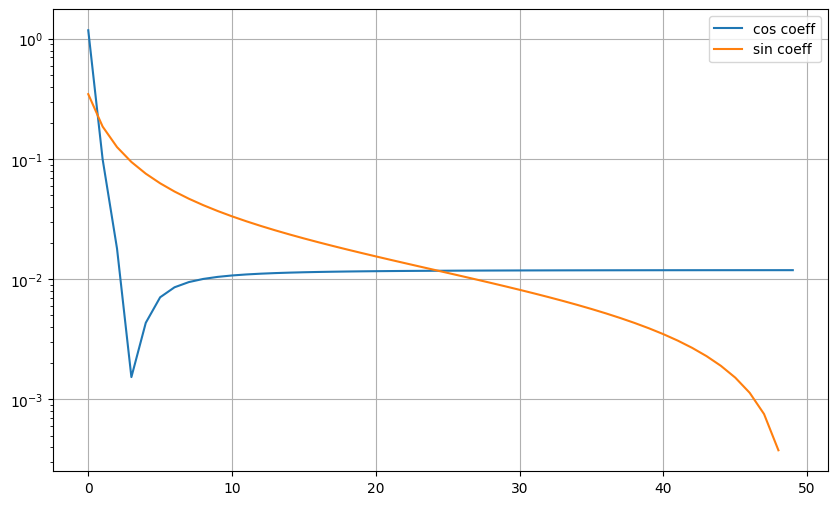

In [49]:
plt.figure(figsize=(10,6))
plt.semilogy(abs(fft_shifted_coeff.real[N//2:]),label='cos coeff')
plt.semilogy(abs(fft_shifted_coeff.imag[N//2+1:]),label='sin coeff')
plt.legend()
plt.grid('both')
plt.show()

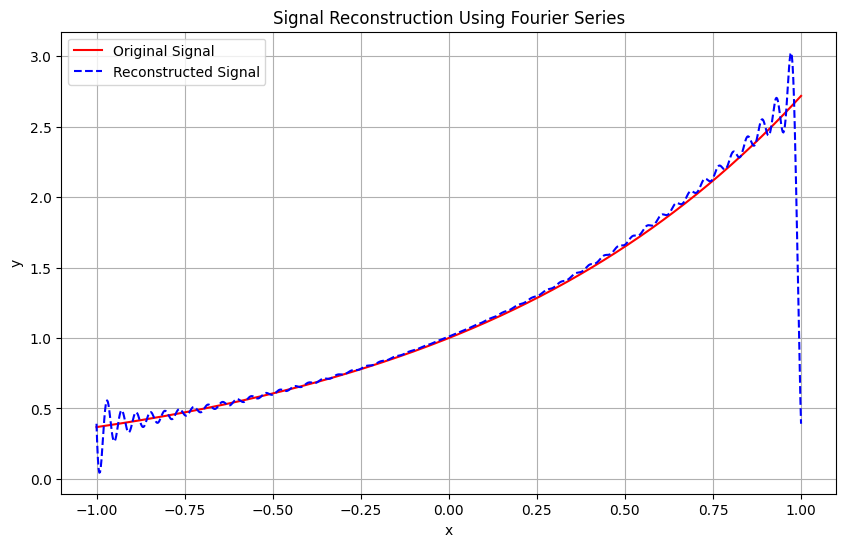

In [50]:
cos_coeff = 2 * fft_coeff.real[:N // 2] 
sin_coeff = -2 * fft_coeff.imag[1:N // 2]

cos_coeff[0] /= 2
if N % 2 == 0:
    cos_coeff[-1] = fft_coeff.real[N // 2]

xx = np.linspace(-1, 1, 1000)
yy = np.array([f(i) for i in xx])

yy_four = np.zeros_like(xx)
for k in range(len(cos_coeff)):
    yy_four += cos_coeff[k] * np.cos(2 * np.pi * k * (xx - xx[0]) / (x[-1] - x[0]))
    if k > 0:
        yy_four += sin_coeff[k - 1] * np.sin(2 * np.pi * k * (xx - xx[0]) / (x[-1] - x[0]))

# Plot original and reconstructed signals
plt.figure(figsize=(10, 6))
plt.plot(xx, yy, 'r', label='Original Signal')
plt.plot(xx, yy_four, 'b--', label='Reconstructed Signal')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Signal Reconstruction Using Fourier Series')
plt.grid()
plt.show()